# Project 7 - Machine Learning - Supervised Learning

Objective: Use linear regression to predict beer consumption

Dataset: Beer Consumption - Sao Paulo

Source: https://www.kaggle.com/dongeorge/beer-consumption-sao-paulo/download

**1. Libraries**

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
from prettytable import PrettyTable
import prettytable
%matplotlib inline

**2. Functions**

In [2]:
def estacao(data):
    if data>= 79 and data <= 171:
        return 'outono'
    elif data>= 172 and data <= 265:
        return 'inverno'
    elif data>= 266 and data <= 356:
        return 'primavera'
    else:
        return 'verao'
    
def dia(num):
    dias = {0:'segunda',1:'terca',2:'quarta',3:'quinta',4:'sexta',5:'sabado',6:'domingo'}
    return dias[num]

def result_regression(model,X_train,X_test,y_train,y_test):
    table = PrettyTable( header=False,horizontal_char ='=', hrules =prettytable.ALL)

    table.add_row(["INTERCEPT ", model.intercept_])
    try:
         table.add_row(["COEFICIENTS",[f"β{i+1} = {round(j,4)}" for i,j in enumerate(model.coef_)]])
    except:
         table.add_row(["COEFICIENTS",[f"β{i+1} = {round(j,4)}" for item in model.coef_ for i,j in enumerate(item)]])
    table.add_row(["R^2 SCORE TRAIN", model.score(X_train,y_train)])
    table.add_row(["R^2 SCORE TEST", model.score(X_test,y_test)])

    return print(table)

**3. Exploring Dataset**

In [3]:
beer = pd.read_csv('Consumo_cerveja.csv', names=['data','t_med_c','t_min_c','t_max_c','precipt_mm','fds','litros'],header=0)

In [4]:
beer.shape

(941, 7)

In [5]:
beer.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 941 entries, 0 to 940
Data columns (total 7 columns):
data          365 non-null object
t_med_c       365 non-null object
t_min_c       365 non-null object
t_max_c       365 non-null object
precipt_mm    365 non-null object
fds           365 non-null float64
litros        365 non-null float64
dtypes: float64(2), object(5)
memory usage: 51.5+ KB


In [6]:
beer.isnull().sum()

data          576
t_med_c       576
t_min_c       576
t_max_c       576
precipt_mm    576
fds           576
litros        576
dtype: int64

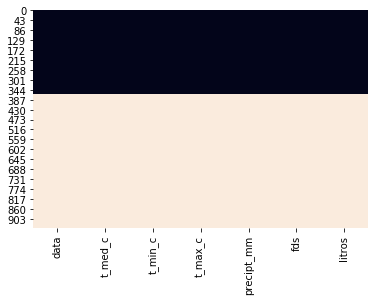

In [7]:
sns.heatmap(beer.isnull(), cbar=False);

In [8]:
beer.dropna(inplace=True)

In [9]:
beer.isnull().sum()

data          0
t_med_c       0
t_min_c       0
t_max_c       0
precipt_mm    0
fds           0
litros        0
dtype: int64

**4. Manipulating Dataset**

In [11]:
beer = pd.read_csv('Consumo_cerveja.csv', names=['data','t_med_c','t_min_c','t_max_c','precipt_mm','fds','litros'],header=0)
beer.dropna(inplace=True)

**4.1 Data columns:**

>setting 'data' column as datetime type,    
>creating 'data_ordinal' containing ordinal datetime,       
>creating 'estacao' based upon date, to find season,      
>creating 'dia_semana' based upon date, to find day of week,      

In [12]:
beer['data'] = beer.loc[:,'data'].apply(lambda x: datetime.strptime(x, '%Y-%m-%d'))

beer['data_ordinal'] = beer.loc[:,'data'].apply(lambda x: x.toordinal())

#finding season
beer['estacao'] = beer.loc[:,'data'].apply(lambda x: estacao(x.timetuple().tm_yday))

#finding day of week
beer['dia_semana'] = beer.loc[:,'data'].apply(lambda x: dia(x.weekday()))

**4.2 temperature columns:**

>setting temperatures to float type;          
>creating categorical column 't_med_cat',        

In [13]:
#converting to float
beer[['t_med_c','t_min_c','t_max_c','precipt_mm']] = beer[['t_med_c','t_min_c','t_max_c','precipt_mm']].applymap(lambda x: float(x.replace(',','.')))

In [14]:
bins_t = [beer['t_med_c'].min(), 
          beer['t_med_c'].mean() - beer['t_med_c'].std(),
          beer['t_med_c'].mean() + beer['t_med_c'].std(),
          beer['t_med_c'].max()]

beer['t_med_cat'] = pd.cut(beer.t_med_c,bins = bins_t, labels=["baixa", "media", "alta"])

**4.3 precipitation column**

Categories:
- Chuva leve: menos de 2,5mm
- Chuva moderada: entre 2,5mm e 7,6mm
- Chuva forte: entre 7,6mm e 50mm
- Chuva violenta: mais de 50mm

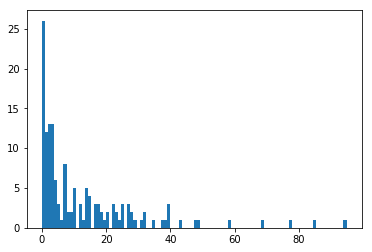

In [15]:
plt.hist(beer[(beer.precipt_mm >0)].loc[:,'precipt_mm'],bins=100);

In [16]:
beer[(beer['precipt_mm'] > 0)].loc[:,'precipt_mm'].min()

0.1

In [17]:
bins_chuva = [0, 0.1, 2.5, 7.6, 50, (beer['precipt_mm'].max() + 1)]

beer['precipt_cat'] = pd.cut(beer['precipt_mm'],bins = bins_chuva, labels=["sem chuva", "chuva leve", "chuva moderada", "chuva forte", "chuva violenta"],right=False)

**4.4 target column:**
      
>creating categorical column 'consumo_breja',

In [18]:
bins_b = [beer['litros'].min() - 1,
          beer['litros'].mean() - beer['litros'].std(),
          beer['litros'].mean() + beer['litros'].std(),
          beer['litros'].max() +1]


beer['consumo_breja'] = pd.cut(beer.litros,bins = bins_b, labels=["baixo", "medio", "alto"])

In [19]:
beer.head(5)

,data,t_med_c,t_min_c,t_max_c,precipt_mm,fds,litros,data_ordinal,estacao,dia_semana,t_med_cat,precipt_cat,consumo_breja
0,2015-01-01,27.30,23.9,32.5,0.0,0.0,25.461,735599,verao,quinta,alta,sem chuva,medio
1,2015-01-02,27.02,24.5,33.5,0.0,0.0,28.972,735600,verao,sexta,alta,sem chuva,medio
2,2015-01-03,24.82,22.4,29.9,0.0,1.0,30.814,735601,verao,sabado,alta,sem chuva,alto
3,2015-01-04,23.98,21.5,28.6,1.2,1.0,29.799,735602,verao,domingo,media,chuva leve,medio
4,2015-01-05,23.82,21.0,28.3,0.0,0.0,28.900,735603,verao,segunda,media,sem chuva,medio


In [20]:
beer.dtypes

data             datetime64[ns]
t_med_c                 float64
t_min_c                 float64
t_max_c                 float64
precipt_mm              float64
fds                     float64
litros                  float64
data_ordinal              int64
estacao                  object
dia_semana               object
t_med_cat              category
precipt_cat            category
consumo_breja          category
dtype: object

**4.5 Get dummies season**

In [21]:
categories = pd.get_dummies(beer['estacao'])

**4.6 Get dummies weekday:**

In [22]:
categories = pd.concat([categories, pd.get_dummies(beer['dia_semana'])], axis=1)

**4.7 Get dummies mean temperature:**

In [23]:
categories = pd.concat([categories, pd.get_dummies(beer['t_med_cat'])], axis=1)

**4.8 Get dummies precipitation:**

In [24]:
categories = pd.concat([categories, pd.get_dummies(beer['precipt_cat'])], axis=1)

In [25]:
categories.head()

,inverno,outono,primavera,verao,domingo,quarta,quinta,sabado,segunda,sexta,terca,baixa,media,alta,sem chuva,chuva leve,chuva moderada,chuva forte,chuva violenta
0,0,0,0,1,0,0,1,0,0,0,0,0,0,1,1,0,0,0,0
1,0,0,0,1,0,0,0,0,0,1,0,0,0,1,1,0,0,0,0
2,0,0,0,1,0,0,0,1,0,0,0,0,0,1,1,0,0,0,0
3,0,0,0,1,1,0,0,0,0,0,0,0,1,0,0,1,0,0,0
4,0,0,0,1,0,0,0,0,1,0,0,0,1,0,1,0,0,0,0


**5. Models**

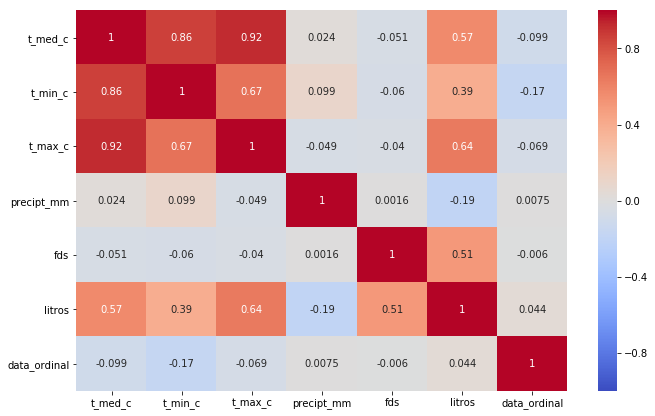

In [26]:
plt.figure(figsize=(11,7))
sns.heatmap(beer.corr(),
            vmin=-1,
            vmax=1,
            cmap='coolwarm',
            annot=True);

**5.1 Regression**

In [27]:
from sklearn.model_selection import (train_test_split,cross_val_score)
from sklearn.metrics import r2_score
from sklearn import linear_model
from sklearn.feature_selection import RFE
from sklearn.svm import SVR
from sklearn.tree import DecisionTreeRegressor

**with 'data_ordinal' column**

In [28]:
# Variables
X = beer.loc[:,['data_ordinal','t_med_c','t_min_c','t_max_c','precipt_mm','fds']]
y = beer.loc[:,'litros']

#Linear Regression Model
l_model = linear_model.LinearRegression()
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size= 0.2, random_state=42)

#Fitting and predicting
l_model.fit(X_train, y_train)
l_prediction = l_model.predict(X_test)

#Result
result_regression(l_model,X_train, X_test, y_train, y_test)

+=================+==============================================================================================+
|    INTERCEPT    |                                      -3407.404681698841                                      |
+=================+==============================================================================================+
|   COEFICIENTS   | ['β1 = 0.0046', 'β2 = 0.0395', 'β3 = -0.0006', 'β4 = 0.6501', 'β5 = -0.0438', 'β6 = 5.2319'] |
+=================+==============================================================================================+
| R^2 SCORE TRAIN |                                      0.7222840422785699                                      |
+=================+==============================================================================================+
|  R^2 SCORE TEST |                                      0.7405154433500203                                      |
+=================+=============================================================

**without 'data_ordinal' column**

In [29]:
# Variables
X = beer.loc[:,['t_med_c','t_min_c','t_max_c','precipt_mm','fds']]
y = beer.loc[:,'litros']

#Linear Regression Model
l_model = linear_model.LinearRegression()
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size= 0.2, random_state=42)

#Fitting and predicting
l_model.fit(X_train, y_train)
l_prediction = l_model.predict(X_test)

#Result
result_regression(l_model,X_train, X_test, y_train, y_test)

+=================+===============================================================================+
|    INTERCEPT    |                               6.419258105234817                               |
+=================+===============================================================================+
|   COEFICIENTS   | ['β1 = 0.0965', 'β2 = -0.0628', 'β3 = 0.6307', 'β4 = -0.0434', 'β5 = 5.1472'] |
+=================+===============================================================================+
| R^2 SCORE TRAIN |                               0.7104068706547428                              |
+=================+===============================================================================+
|  R^2 SCORE TEST |                               0.7427938181737361                              |
+=================+===============================================================================+


**Using RFE**

In [30]:
rfe = RFE(l_model, n_features_to_select = 3, verbose =3)
rfe.fit(X_train,y_train)

Fitting estimator with 5 features.
Fitting estimator with 4 features.


RFE(estimator=LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None,
         normalize=False),
  n_features_to_select=3, step=1, verbose=3)

In [31]:
rfe.ranking_

array([2, 1, 1, 3, 1])

In [32]:
X_train.head(0)

,t_med_c,t_min_c,t_max_c,precipt_mm,fds


In [33]:
X_modified = X = beer.loc[:,['t_max_c','precipt_mm','fds']]

#Linear Regression Model
l_model_2 = linear_model.LinearRegression()
X_train_2, X_test_2, y_train_2, y_test_2 = train_test_split(X_modified, y, test_size= 0.2, random_state=42)

#Fitting and predicting
l_model_2.fit(X_train_2, y_train_2)
l_prediction_2 = l_model_2.predict(X_test_2)

#Result
result_regression(l_model_2,X_train_2, X_test_2, y_train_2, y_test_2)

+=================+===============================================+
|    INTERCEPT    |               6.366518335274023               |
+=================+===============================================+
|   COEFICIENTS   | ['β1 = 0.6685', 'β2 = -0.0438', 'β3 = 5.155'] |
+=================+===============================================+
| R^2 SCORE TRAIN |               0.7101374278594039              |
+=================+===============================================+
|  R^2 SCORE TEST |               0.7443386646797043              |
+=================+===============================================+


**Using SVM Regressor**

In [34]:
# Variables
X_svr = beer.loc[:,['t_med_c','t_min_c','t_max_c','precipt_mm','fds']]
y_svr = beer.loc[:,'litros']

#Linear Regression Model
svm_model = SVR(kernel = 'linear', gamma='auto')
#svm_model = SVR(gamma='auto')
X_train_svr, X_test_svr, y_train_svr, y_test_svr = train_test_split(X_svr, y_svr, test_size= 0.2, random_state=42)

#Fitting and predicting
svm_model.fit(X_train_svr, y_train_svr)
svm_prediction = svm_model.predict(X_test_svr)

#Result
result_regression(svm_model,X_train_svr,X_test_svr,y_train_svr,y_test_svr)

+=================+=============================================================================+
|    INTERCEPT    |                                  [7.247705]                                 |
+=================+=============================================================================+
|   COEFICIENTS   | ['β1 = 0.2715', 'β2 = -0.225', 'β3 = 0.5645', 'β4 = -0.024', 'β5 = 4.4921'] |
+=================+=============================================================================+
| R^2 SCORE TRAIN |                              0.7007864821520006                             |
+=================+=============================================================================+
|  R^2 SCORE TEST |                              0.7075926968898265                             |
+=================+=============================================================================+


**Using SVM Regressor (3 best features)**

In [35]:
# Variables
X_svr_3b = beer.loc[:,['t_max_c','precipt_mm','fds']]
y_svr_3b = beer.loc[:,'litros']

#Linear Regression Model
svm_model_3b = SVR(kernel = 'linear', gamma='auto')
#svm_model = SVR(gamma='auto')
X_train_svr_3b, X_test_svr_3b, y_train_svr_3b, y_test_svr_3b = train_test_split(X_svr_3b, y_svr_3b, test_size= 0.2, random_state=42)

#Fitting and predicting
svm_model_3b.fit(X_train_svr_3b, y_train_svr_3b)
svm_prediction_3b = svm_model_3b.predict(X_test_svr_3b)

#Result
result_regression(svm_model_3b,X_train_svr_3b, X_test_svr_3b, y_train_svr_3b, y_test_svr_3b)

+=================+================================================+
|    INTERCEPT    |                  [6.35370609]                  |
+=================+================================================+
|   COEFICIENTS   | ['β1 = 0.6718', 'β2 = -0.0325', 'β3 = 4.4792'] |
+=================+================================================+
| R^2 SCORE TRAIN |               0.7040527784065155               |
+=================+================================================+
|  R^2 SCORE TEST |               0.7256925082803083               |
+=================+================================================+


**Using DecisionTree Regressor(3 best features)**

In [36]:
# Variables
X_tree_r = beer.loc[:,['t_max_c','precipt_mm','fds']]
y_tree_r = beer.loc[:,'litros']

#Linear Regression Model
tree_r_model = DecisionTreeRegressor(random_state=42)
X_train_tree_r, X_test_tree_r, y_train_tree_r, y_test_tree_r = train_test_split(X_tree_r, y_tree_r, test_size= 0.2, random_state=42)

#Fitting and predicting
tree_r_model.fit(X_train_tree_r, y_train_tree_r)
tree_r_prediction = tree_r_model.predict(X_test_tree_r)

#Result
print(f'R^2 SCORE TRAIN: {tree_r_model.score(X_train_tree_r,y_train_tree_r)}')
print(f'R^2 SCORE TEST: {tree_r_model.score(X_test_tree_r,y_test_tree_r)}')
print()
print(cross_val_score(tree_r_model, X_tree_r, y_tree_r,cv=3))

R^2 SCORE TRAIN: 0.9503431252723982
R^2 SCORE TEST: 0.5972415641561792

[0.28252489 0.51999935 0.4357073 ]


**5.2 Categorical**

In [37]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
import scikitplot as skplt
from sklearn.neighbors import KNeighborsClassifier

**Using Decision Tree Classifier**

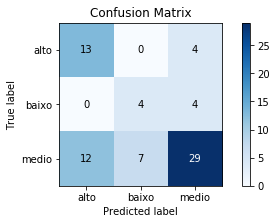

In [38]:
# Variables
X_tree_c = categories.copy()
#y_tree_c = beer.consumo_breja.apply(lambda x: 1 if x =="baixo" else (2 if x=="medio" else 3))
y_tree_c = beer.consumo_breja.copy()

#Model
tree_c_model = DecisionTreeClassifier(random_state=42)
X_train_tree_c, X_test_tree_c, y_train_tree_c, y_test_tree_c = train_test_split(np.array(X_tree_c), np.array(y_tree_c), test_size= 0.2, random_state=42)

#Fitting and predicting
tree_c_model.fit(X_train_tree_c, y_train_tree_c)
tree_c_prediction = tree_c_model.predict(X_test_tree_c)

#Result
skplt.metrics.plot_confusion_matrix(y_test_tree_c, tree_c_prediction,figsize=(7,3))

In [39]:
print(classification_report(y_test_tree_c, tree_c_prediction))

              precision    recall  f1-score   support

        alto       0.52      0.76      0.62        17
       baixo       0.36      0.50      0.42         8
       medio       0.78      0.60      0.68        48

   micro avg       0.63      0.63      0.63        73
   macro avg       0.56      0.62      0.57        73
weighted avg       0.68      0.63      0.64        73



**Using Logistic Regression**

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:460: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)


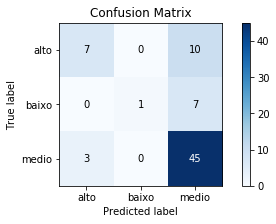

In [40]:
# Variables
X_lg = categories.copy()
#y_tree_c = beer.consumo_breja.apply(lambda x: 1 if x =="baixo" else (2 if x=="medio" else 3))
y_lg = beer.consumo_breja.copy()

#Model
lg_model = LogisticRegression()
X_train_lg, X_test_lg, y_train_lg, y_test_lg = train_test_split(np.array(X_lg), np.array(y_lg), test_size= 0.2, random_state=42)

#Fitting and predicting
lg_model.fit(X_train_lg, y_train_lg)
lg_prediction = lg_model.predict(X_test_lg)

#Result
skplt.metrics.plot_confusion_matrix(y_test_lg, lg_prediction,figsize=(7,3))

In [41]:
print(classification_report(y_test_lg, lg_prediction))

              precision    recall  f1-score   support

        alto       0.70      0.41      0.52        17
       baixo       1.00      0.12      0.22         8
       medio       0.73      0.94      0.82        48

   micro avg       0.73      0.73      0.73        73
   macro avg       0.81      0.49      0.52        73
weighted avg       0.75      0.73      0.68        73



**Using SVM Classifier**

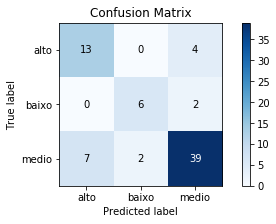

In [42]:
# Variables
X_svc = categories.copy()
y_svc = beer.consumo_breja.copy()

#Model
svc_model = SVC(kernel='linear',gamma='auto')
X_train_svc, X_test_svc, y_train_svc, y_test_svc = train_test_split(np.array(X_svc), np.array(y_svc), test_size= 0.2, random_state=42)

#Fitting and predicting
svc_model.fit(X_train_svc, y_train_svc)
svc_prediction = svc_model.predict(X_test_svc)

#Result
skplt.metrics.plot_confusion_matrix(y_test_lg, svc_prediction,figsize=(7,3))

In [43]:
print(classification_report(y_test_lg, svc_prediction))

              precision    recall  f1-score   support

        alto       0.65      0.76      0.70        17
       baixo       0.75      0.75      0.75         8
       medio       0.87      0.81      0.84        48

   micro avg       0.79      0.79      0.79        73
   macro avg       0.76      0.78      0.76        73
weighted avg       0.80      0.79      0.80        73



**Using KNN Classifier**

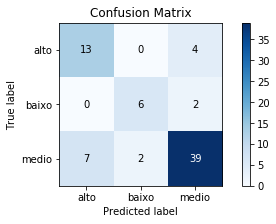

In [44]:
# Variables
X_knn = categories.copy()
y_knn = beer.consumo_breja.copy()

#Model
knn_model = KNeighborsClassifier(n_neighbors=3)
X_train_knn, X_test_knn, y_train_knn, y_test_knn = train_test_split(np.array(X_knn), np.array(y_knn), test_size= 0.2, random_state=42)

#Fitting and predicting
knn_model.fit(X_train_knn, y_train_knn)
knn_prediction = svc_model.predict(X_test_knn)

#Result
skplt.metrics.plot_confusion_matrix(y_test_knn, knn_prediction,figsize=(7,3))

In [45]:
print(classification_report(y_test_knn, knn_prediction))

              precision    recall  f1-score   support

        alto       0.65      0.76      0.70        17
       baixo       0.75      0.75      0.75         8
       medio       0.87      0.81      0.84        48

   micro avg       0.79      0.79      0.79        73
   macro avg       0.76      0.78      0.76        73
weighted avg       0.80      0.79      0.80        73



+++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++

# TODO

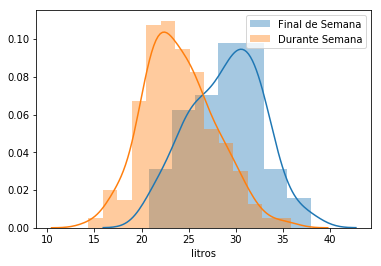

In [46]:
sns.distplot(beer.loc[beer['fds'] == 1,'litros']);

sns.distplot(beer.loc[beer['fds'] == 0,'litros']);
plt.legend(['Final de Semana', 'Durante Semana']);

In [47]:
#class Machine:
#    """
#    Calcula e 
#    """
#    def __init__(self,...):
#
#    def category(X_train,X_test,y_train,y_test):
#    
#    def continuous(X_train,X_test,y_train,y_test):
        

In [48]:
#beer[(beer['Final de Semana']==1.0)]
#beer.loc[:,'Final de Semana']